In [31]:
#importing libraries
import numpy
from matplotlib import pyplot
import matplotlib.cm as cm
%matplotlib inline
from scipy.linalg import solve

In [32]:
#setting initial conditions as asked in the assignement
n = 192

Du, Dv, F, k = 0.00016, 0.00008, 0.035, 0.065 # Bacteria 1 

dh = 5/(n-1)

T = 8000

dt = .9 * dh**2 / (4*max(Du,Dv))

nt = int(T/dt)

In [33]:
uvinitial = numpy.load('./data/uvinitial.npz')
U = uvinitial['U']
V = uvinitial['V']

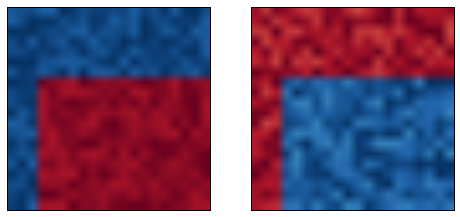

In [34]:
fig = pyplot.figure(figsize=(8,5))
pyplot.subplot(121)
pyplot.imshow(U, cmap = cm.RdBu)
pyplot.xticks([]), pyplot.yticks([]);
pyplot.subplot(122)
pyplot.imshow(V, cmap = cm.RdBu)
pyplot.xticks([]), pyplot.yticks([]);

In [35]:

def constructMatrix(n, sigma):
    """ Generate implicit matrix for 2D Gray-Scott model with Neumann BC
    Assumes dx = dy
    
    Parameters:
    ----------
    nx   : int
        number of discretization points in x
    ny   : int
        number of discretization points in y
    sigma: float
        coefficient in the diagonal (i.e. sigma + F for u and sigma + F + k for v)
        
    Returns:
    -------
    A: 2D array of floats
        Matrix of implicit 2D heat equation
    """
    
    A = numpy.zeros(((n-2)*(n-2),(n-2)*(n-2)))
    
    row_number = 0 # row counter
    for j in range(1,n-1):
        for i in range(1,n-1):
            
            # Corners
            if i==1 and j==1: # Bottom left corner
                A[row_number,row_number] = sigma + 2 # Set diagonal
                A[row_number,row_number+1] = -1      # fetch i+1
                A[row_number,row_number+n-2] = -1   # fetch j+1
                
            elif i==n-2 and j==1: # Bottom right corner
                A[row_number,row_number] = sigma+2 # Set diagonal
                A[row_number,row_number-1] = -1      # Fetch i-1
                A[row_number,row_number+n-2] = -1   # fetch j+1
                
            elif i==1 and j==n-2: # Top left corner
                A[row_number,row_number] = sigma+3   # Set diagonal
                A[row_number,row_number+1] = -1        # fetch i+1
                A[row_number,row_number-(n-2)] = -1   # fetch j-1
                
            elif i==n-2 and j==n-2: # Top right corner
                A[row_number,row_number] = sigma+2   # Set diagonal
                A[row_number,row_number-1] = -1        # Fetch i-1
                A[row_number,row_number-(n-2)] = -1   # fetch j-1
              
            # Sides
            elif i==1: # Left boundary
                A[row_number,row_number] = sigma+3 # Set diagonal
                A[row_number,row_number+1] = -1      # fetch i+1
                A[row_number,row_number+n-2] = -1   # fetch j+1
                A[row_number,row_number-(n-2)] = -1 # fetch j-1
            
            elif i==n-2: # Right boundary
                A[row_number,row_number] = sigma+3 # Set diagonal
                A[row_number,row_number-1] = -1      # Fetch i-1
                A[row_number,row_number+n-2] = -1   # fetch j+1
                A[row_number,row_number-(n-2)] = -1 # fetch j-1
                
            elif j==1: # Bottom boundary
                A[row_number,row_number] = sigma+3 # Set diagonal
                A[row_number,row_number+1] = -1      # fetch i+1
                A[row_number,row_number-1] = -1      # fetch i-1
                A[row_number,row_number+n-2] = -1   # fetch j+1
                
            elif j==n-2: # Top boundary
                A[row_number,row_number] = sigma+3 # Set diagonal
                A[row_number,row_number+1] = -1      # fetch i+1
                A[row_number,row_number-1] = -1      # fetch i-1
                A[row_number,row_number-(n-2)] = -1 # fetch j-1
             
            # Interior points
            else:
                A[row_number,row_number] = sigma+4 # Set diagonal
                A[row_number,row_number+1] = -1      # fetch i+1
                A[row_number,row_number-1] = -1      # fetch i-1
                A[row_number,row_number+n-2] = -1   # fetch j+1
                A[row_number,row_number-(n-2)] = -1 # fetch j-1
                
            row_number += 1 # Jump to next row of the matrix!
    
    return A           

In [36]:
def generateRHSu(n, sigma, dt, F, v, u):
    """ Generates right-hand side for 2D implicit heat equation with Neumann BCs
        Assumes dx=dy, Neumann BCs = 0
        
        Paramenters:
        -----------
        nx    : int
            number of discretization points in x
        ny    : int
            number of discretization points in y
        sigma : float
            dx^2/Du
        dt    : float
            time-step
        F     : float
            feed rate
        v     : array of float
            Concentration of v in current time
        u     : array of float
            Concentration of u in current time
        
        
        Returns:
        -------
        RHS  : array of float
            Right hand side of 2D implicit Gray-Scott model equation
    """
    RHS = numpy.zeros((n-2)*(n-2))
    
    row_number = 0 # row counter
    for j in range(1,n-1):
        for i in range(1,n-1):
            
                RHS[row_number] = sigma*(u[j,i]/dt - u[j,i]*v[j,i]*v[j,i] + F)
                row_number += 1 #Jump to next row!
    
    return RHS

def generateRHSv(nx, sigma, dt, Fk, v, u):
    """Generates right-hand side for 2D implicit heat equation with Neumann BCs
        Assumes dx=dy, Neumann BCs = 0
        
        Paramenters:
        -----------
        nx    : int
            number of discretization points in x
        ny    : int
            number of discretization points in y
        sigma : float
            dx^2/Dv
        dt    : float
            time-step
        Fk     : float
            feed + kill rate
        v     : array of float
            Concentration of v in current time
        u     : array of float
            Concentration of u in current time
        
        
        Returns:
        -------
        RHS  : array of float
            Right hand side of 2D implicit Gray-Scott model equation
        """
    RHS = numpy.zeros((n-2)*(n-2))
    
    row_number = 0 # row counter
    for j in range(1,n-1):
        for i in range(1,n-1):
                
            RHS[row_number] = sigma * (v[j,i]/dt + u[j,i]*v[j,i]*v[j,i])  
            row_number += 1 #Jump to next row!
            
        return RHS

In [37]:
def map_1Dto2D(n, u_1D):
    """ Takes solution of linear system, stored in 1D, 
    and puts them in a 2D array with the BCs
    Valid Neumann with zero flux top and right
        
    Parameters:
    ----------
        nx  : int
            number of nodes in x direction
        ny  : int
            number of nodes in y direction
        u_1D: array of floats
            solution of linear system
            
    Returns:
    -------
        T: 2D array of float
            solution stored in 2D array with BCs
    """
    u = numpy.zeros((n,n))
    
    row_number = 0
    for j in range(1,n-1):
        for i in range(1,n-1):
            u[j,i] = u_1D[row_number]
            row_number += 1
    # Neumann BC
    u[0,:] = u[1,:]
    u[:,0] = u[:,1]
    u[-1,:] = u[-2,:]
    u[:,-1] = u[:,-2]
    
    return u 

In [38]:
def takeAStep(A_u, A_v, u, v, sigmaU, sigmaV, F, k, n, dt):
    """
    
    Parameters:
    -----------
    u : 2D array of float
        concentration of u
    v : 2D array of float
        concentration of v
    sigmaU : float
        Du*dt/dx^2
    sigmaV : float
        Dv*dt/dx^2
    F : float
        Feed rate
    k : float
        kill rate
    """
    
    bu = generateRHSu(n, sigmaU, dt, F, v, u)
    bv = generateRHSv(n, sigmaV, dt, F+k, v, u)
    u_1D = solve(A_u, bu)
    v_1D = solve(A_v, bv)
    u = map_1Dto2D(n, u_1D)
    v = map_1Dto2D(n, v_1D)
    
    return u
    

In [39]:
A_u = constructMatrix(n, dh*dh/Du/dt + F)
A_v = constructMatrix(n, dh*dh/Dv/dt + F + k)

In [43]:
for i in range(nt):    
    U=takeAStep(A_u, A_v, U, V, dh*dh/dt/Du, dh*dh/dt/Dv, F, k, n, dt)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
11.697768926620483


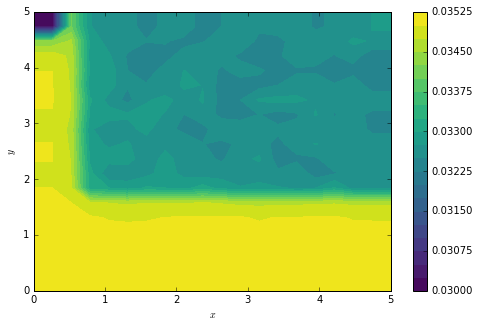

In [44]:
x = numpy.linspace(0,5.,n)
y = numpy.linspace(0,5.,n)
pyplot.figure(figsize=(8,5))
pyplot.contourf(x,y,U,20,cmap=cm.viridis)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar();